<a id="top"></a>
# HST WFC3 Point Spread Function Modeling   <img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

***
<a id="learning"></a>
## Learning Goals
This notebook demonstrates how to create Point Spread Function (PSF) models for HST [Wide Field Camera 3 (WFC3)](https://www.stsci.edu/hst/instrumentation/wfc3) observations.

The tutorial will allow users to complete the following tasks:

 - Perform simple aperture photometry on science images for comparison with PSF photometry.
 - Retrieve or create a PSF model for WFC3 single exposures (FLCs) and drizzled (DRZs) images.
 - Complete basic science workflows including PSF photometry, subtraction, and decomposition.

<a id="toc"></a>
## Table of Contents

**&ensp;[Learning Goals](#learning)** <br>
**&ensp;[1. Introduction](#introduction)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Environment Setup](#environment)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Import Packages](#import)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3 Download Data](#data)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4 Aperture Photometry](#aperture)** <br>
**&ensp;[2. Exposure PSF Models](#mainc)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Analytical PSF Models](#analytical)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Empirical PSF Models](#empirical)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 Default Models](#empirical-1)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 Focus Perturbation](#empirical-2)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 Spatial Perturbation](#empirical-3)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Stacked PSF Models](#stacked)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 Stellar Stacks](#stellar)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 MAST Stacks](#mast)** <br>
**&ensp;[3. Drizzle PSF Models](#drizzles)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Create Drizzle](#create)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Stack Stars](#stack)** <br>
**&ensp;[Conclusions](#conclusions)** <br>
**&ensp;[About this Notebook](#about)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[Additional Resources](#additional)** <br>
**&ensp;&nbsp;&nbsp;&nbsp;&nbsp;[Software Citations](#cite)** <br>

**Acronyms:**
- Point Spread Function (PSF)
- Hubble Space Telescope (HST)
- Wide Field Camera 3 (WFC3)
- WFC3 InfraRed detector (IR)
- WFC3 Ultraviolet and VISable detector (UVIS)
- Wide Field and Planetary Camera 2 (WFPC2)
- Mikulski Archive for Space Telescopes (MAST)
- Flexible Image Transport System (FITS)

<a id="introduction"></a>
## 1. Introduction
[Table of Contents](#toc)

***

**What is the Point Spread Function and why do we want to model it?**

The purpose of a telescope is to collect, magnify, and record the intensity of light from astronomical sources. A telescope's ability to to resolve the size of objects is limited by its spatial resolution, which is determined by its aperture and the wavelength of light being observed, such that every telescope is fundamentally limited by the diffraction nature of light. The minimum size of an image that the light can be focused onto is known as the Airy disk. In addition, the shape of the image will be altered by any optical abberations in the telescopes system of mirrors, lenses, filters, and camera detectors. When observing unresolved point sources such as stars, these factors determine the size and shape of the focused image. This distribution of light as a function of position on the telescopes detectors is known as the systems Point Spread Function (PSF). More simply, the PSF describes how the light from an unresolved source is distributed across multiple pixels when it is recorded by the telescopes camera.

While a well-focused telescope produces a very small image of point sources, the shape will be distorted and the light is effectively scattered to an infinite radius. Therefore, a model of the PSF is required to accurately measure astrometry (positions) and photometry (brightnesses) of objects in astronomical images. In the case of the HST WFC3 this is especially important because the images are undersampled, which means the telescope is capable of delivering higher resolution than the detector pixels can record. The PSF will vary depending on the telescopes focus, and also significantly with location on the WFC3 detector due to optical distortions in the light path that are designed to minimize light loss by reducing the number of optical reflections. For these reasons, the WFC3 team has produced a library of PSF models and tools for users.

Finally, astrometric and photometric measurements can generally be made either from individual calibrated exposures known as [FLTs and FLCs](https://hst-docs.stsci.edu/wfc3dhb/chapter-2-wfc3-data-structure/2-1-types-of-wfc3-files) for WFC3, or exposures that are combined into a mosaic through drizzling. In theory, modeling individual exposures is always preferable because these images are on the telescopes intrinsic pixel grid without any modification. However, this requires bright unresolved sources that have been observed with a relatively short exposure time, so that images are not strongly affected by cosmic rays. In addition, many astronomical sources are very faint, requiring a combination of multiple dithered exposures to obtain sufficient signal to noise for analysis. For these reasons, we will demonstrate techniques for constructing PSF models for both individual calibrated exposures and drizzled mosaics.

Users looking for a fundamental introduction to [aperture photometry](https://boyce-astro.org/aperture-photometry/) and [PSF photometry](https://boyce-astro.org/point-spread-function-psf/) may find this excellent series of [video tutorials](https://boyce-astro.org/videos/photometry/) by Boyce-Astro helpful, as well as this description of the [Airy Disk](https://www.edmundoptics.com/knowledge-center/application-notes/imaging/limitations-on-resolution-and-contrast-the-airy-disk/) by Edmund Optics. In addition, detailed information on WFC3 can be found on the [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3), [WFC3 PSF Webpage](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/psf), [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb), and [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb). Finally, the publication by [Anderson & King 2000](https://ui.adsabs.harvard.edu/abs/2000PASP..112.1360A/abstract) provides foundational information about the effects of undersampling on the HST PSF.

<a id="environment"></a>
### 1.1 Environment Setup
[Table of Contents](#toc)

***

This Jupyter Notebook requires users to install the ```stenv``` Python environment maintained by STScI.

Detailed installation instructions can be found on the stenv [readthedocs](https://stenv.readthedocs.io/en/latest/getting_started.html). For completeness, the terminal commands for MacOS with ARM chips are included below:

<code>conda update conda
conda env create --name stenv2024 --file https://github.com/spacetelescope/stenv/releases/download/2024.02.05/stenv-macOS-ARM64-py3.11-2024.02.05.yaml
conda activate stenv2024
conda clean -t
jupyter lab</code>

<div class="alert alert-block alert-info"><b>NOTE:</b> The following non-Python tools are needed to run some advanced features of the Jupyter Notebook. Specifically, a FORTRAN compiler and the <code>hst1pass</code> FORTRAN code are only required for PSF perturbation with individual exposures (FLTs/FLCs). These tools are not required for stacking stars or creating PSF models for drizzled images (DRCs/DRZs). </div>

 - [**hst1pass**](https://www.stsci.edu/~jayander/HST1PASS/) - FORTRAN code for performing photometry and PSF perturbation as documented in [Anderson 2022 (WFC3 2022-5)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2022/WFC3-ISR-2022-05.pdf).

Below are instructions for installing a FORTRAN complier and building the hst1pass executable on MacOS with ARM chips:

FORTRAN can be installed by typing the command ```conda install -c conda-forge gfortran``` into a terminal. If the installation is successful, then typing ```gfortran --version``` should return a message similar to the following: ```GNU Fortran (GCC) 13.2.0 Copyright (C) 2023 Free Software Foundation, Inc.```.

Next, to install hst1pass proceed to [https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/](https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/) and download the latest version of ```hst1pass.F```, e.g.: ```hst1pass.2023.11.07_v1f.F```. On MacOS, save this to your computer as ```hst1pass_darwin.F```. Finally, compile the code using the command: ```gfortran hst1pass_darwin.F -o hst1pass_darwin.e```.

<a id="import"></a>
### 1.2 Import Packages
[Table of Contents](#toc)

***

The following Python packages are required to run the Jupyter Notebook:
 - [**os**](https://docs.python.org/3/library/os.html) - change and make directories
 - [**glob**](https://docs.python.org/3/library/glob.html) - gather lists of filenames
 - [**shutil**](https://docs.python.org/3/library/shutil.html) - copy files between folders
 - [**tarfile**](https://docs.python.org/3/library/tarfile.html) - read and write compressed tar files
 - [**urllib**](https://docs.python.org/3/library/urllib.html) - download files hosted online
 - [**ipython**](https://ipython.org) - cell formatting and interactives
     - [display.clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output) - clear text from cells
 - [**numpy**](https://numpy.org) - math and array functions
     - [percentile](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) - lognorm percentile clipping
 - [**matplotlib**](https://matplotlib.org) - create graphics
     - [pyplot](https://matplotlib.org/stable/tutorials/pyplot.html) - make figures and graphics
     - [colors.LogNorm](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.LogNorm.html) - display image normalization
     - [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) - overlay rectangular regions
 - [**astroquery**](https://astroquery.readthedocs.io/en/latest/) - download astronomical data
     - [mast.Observations](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html) - query MAST database
 - [**astropy**](https://www.astropy.org) - model fitting and file handling
     - [io.fits](https://docs.astropy.org/en/stable/io/fits/) - import FITS files
     - [table.QTable](https://docs.astropy.org/en/stable/api/astropy.table.QTable.html) - tables with physical units
     - [modeling.models](https://docs.astropy.org/en/stable/modeling/models.html) - Gaussian and Moffat models
     - [modeling.fitting](https://docs.astropy.org/en/stable/modeling/fitting.html) - fitting methods for models
     - [visualization.simple_norm](https://docs.astropy.org/en/stable/api/astropy.visualization.mpl_normalize.simple_norm.html) - display image normalization
     - [stats.sigma_clipped_stats](https://docs.astropy.org/en/stable/api/astropy.stats.sigma_clipped_stats.html) - mean, median, and standard deviation
     - [stats.sigma_clip](https://docs.astropy.org/en/stable/api/astropy.stats.sigma_clip.html) - sigma-clip provided data
 - [**photutils**](https://photutils.readthedocs.io/en/stable/index.html) - aperture and PSF photometry tools
     - [detection.DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder) - finding stars in images
     - [detection.find_peaks](https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks) - finding peaks in images
     - [photutils.centroids](https://photutils.readthedocs.io/en/stable/centroids.html) - finding stellar centroids
     - [photutils.aperture](https://photutils.readthedocs.io/en/stable/aperture.html) - aperture photometry tools
     - [photutils.psf](https://photutils.readthedocs.io/en/stable/psf.html) - PSF photometry tools
         - [PSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.PSFPhotometry.html#photutils.psf.PSFPhotometry) - perform PSF photometry
         - [SourceGrouper](https://photutils.readthedocs.io/en/stable/api/photutils.psf.SourceGrouper.html#photutils.psf.SourceGrouper) - group sources for fitting
         - [IntegratedGaussianPRF](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IntegratedGaussianPRF.html) - Gaussian model for PSF fitter
         - [GriddedPSFModel](https://photutils.readthedocs.io/en/stable/api/photutils.psf.GriddedPSFModel.html#photutils.psf.GriddedPSFModel) - enables spatially-dependent PSF grids
         - [STDPSFGrid](https://photutils.readthedocs.io/en/stable/api/photutils.psf.STDPSFGrid.html#photutils.psf.STDPSFGrid) - reads STScI standard PSF models into a grid
         - [stdpsf_reader](https://photutils.readthedocs.io/en/stable/api/photutils.psf.stdpsf_reader.html#photutils.psf.stdpsf_reader) - reads STScI standard PSF format models
         - [FittableImageModel](https://photutils.readthedocs.io/en/stable/api/photutils.psf.FittableImageModel.html#photutils.psf.FittableImageModel) - convert stacked stars to fitable model
 - [**scipy**](https://scipy.org) - mathematical interpolation and shift functions
     - [ndimage.shift](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.shift.html) - fractional array shifts
 - [**drizzlepac**](https://www.stsci.edu/scientific-community/software/drizzlepac) - combine HST images into mosaics
     - [astrodrizzle](https://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html) - combine exposures by drizzling
     - [tweakreg](https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html) - align exposures to a common WCS

In [ ]:
import os
import glob
import shutil
import tarfile
from IPython.display import clear_output
import numpy
import matplotlib
import matplotlib.pyplot
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from astroquery.mast import Observations
from astropy.io import fits
from astropy.table import Table, QTable
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import ApertureStats
from photutils.psf import PSFPhotometry
from photutils.psf import SourceGrouper
from photutils.psf import IntegratedGaussianPRF
from photutils.psf import GriddedPSFModel
from photutils.psf import STDPSFGrid
from photutils.psf import FittableImageModel
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

# Custom functions written in psf_utilities.py.
from psf_utilities import save_figure
from psf_utilities import setup_matplotlib
from psf_utilities import create_mask
from psf_utilities import plot_apertures
from psf_utilities import plot_psf_results
from psf_utilities import download_psf_model
from psf_utilities import make_cutouts
from psf_utilities import stack_cutouts
from psf_utilities import plot_cutout_grid

# Custom functions written in mast_api_psf.py.
import mast_api_psf

Set the main code, data, PSF, and plot directories. Set the backend configuration option to 'retina', which greatly improves the resolution of figures in notebooks.

In [ ]:
code_dir = os.getcwd()+'/'
data_dir = code_dir+'data/'
psfs_dir = code_dir+'psfs/'
plot_dir = code_dir+'plot/'
driz_dir = code_dir+'driz/'
tweak_dir = code_dir+'tweak/'

print('\nThe code_dir is:', code_dir)

os.chdir(code_dir)

try:
    os.mkdir('data')
except FileExistsError:
    print('Data directory exists.')
try:
    os.mkdir('psfs')
except FileExistsError:
    print('PSFs directory exists.')
try:
    os.mkdir('plot')
except FileExistsError:
    print('Plot directory exists.')
try:
    os.mkdir('driz')
except FileExistsError:
    print('Driz directory exists.')
try:
    os.mkdir('tweak')
except FileExistsError:
    print('Tweak directory exists.')

%config InlineBackend.figure_format = 'retina'

<a id="data"></a>
### 1.3 Download Data
[Table of Contents](#toc)

***

In this example, we'll be using HST WFC3 imaging of the globular cluster Omega Centauri (NGC 5139). Specifically, utilizing exposures that are not centered on the nucleus so there is a moderate density of bright stars. This source was chosen because it serves as a frequent target for both science and calibration exposures, and has been observed with every UVIS and IR filter onboard WFC3. A complete list of WFC3 filters is available in the Data Handbook for the [UVIS](https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-5-uvis-spectral-elements) and [IR](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-5-ir-spectral-elements) channels. First, we use astroquery to retrieve the calibrated exposure from MAST.

In [ ]:
hst_wfc3_f606w_file = 'id8048dyq_flc.fits'

Observations.download_file('mast:HST/product/'+hst_wfc3_f606w_file, local_path=data_dir+hst_wfc3_f606w_file, cache=True)

Next, let's display the image of Omega Centauri and add a rectangle showing the region of the image that we will focus on in this analysis. We select a small region of the image that contains isolated and blended stars to highlight key concepts in aperture and PSF photometry. The WFC3/UVIS pixel scale is 0.0395 arcseconds per pixel so selecting a region of 75 pixels corresponds to approximately 3 arcseconds. The UVIS detector has two chips that can be accessed in the FITS files from extensions ```['SCI', 1]``` and ```['SCI', 2]```. The lower-left corner of the detector is the location (0, 0), so we use the ```origin = 'lower'``` option. Finally, we display the image on a logarithmic scale to view both very faint and bright stars simultaneously.

In [ ]:
hdul = fits.open(data_dir+hst_wfc3_f606w_file)
sci_data = hdul['SCI', 1].data
print('The image dimensions are:', numpy.shape(sci_data))

my_figure_size, my_fontsize = setup_matplotlib('notebook', 1.2)
figure, axes = matplotlib.pyplot.subplots(1, 1, figsize=my_figure_size)
cutout_size = 75 # 75 WFC3 UVIS pixels = 3 arcseconds.

axes.add_patch(Rectangle((1818-cutout_size/2, 986-cutout_size/2), width=cutout_size, height=cutout_size, fill=None, color='w'))
norm = LogNorm(vmin=numpy.percentile(sci_data, 10.0), vmax=numpy.percentile(sci_data, 99.9))
axes.imshow(sci_data, cmap='gray', origin='lower', norm=norm)
matplotlib.pyplot.show()

<a id="aperture"></a>
### 1.4 Aperture Photometry
[Table of Contents](#toc)

***

First, we can perform simple aperture photometry on the image. This consists of detecting stars in the image, assigning them an aperture within which to measure the enclosed flux, and creating a background annulus that is used to subtract the background level. In ground-based astronomy this is commonly referred to as the 'sky' level. In this example, we create a mask within the plot_apertures function so that we only find and measure the properties of stars that are within our zoomed-in box region.

In [ ]:
# Calculate statistics for the background, initialize the star finder, locate the stars, and assign flux apertures.
mean, median, std = sigma_clipped_stats(sci_data, sigma=3.0)
daofind = DAOStarFinder(threshold=500, fwhm=3.0, roundhi=0.5)
mask = create_mask(sci_data, cutout_size, 1818, 986)
sources = daofind(sci_data - median, mask=mask)
positions = numpy.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_stellar = CircularAperture(positions, r=5.0)
apertures_annulus = CircularAnnulus(positions, r_in=9, r_out=12)
phot_table = aperture_photometry(sci_data, apertures_stellar)

# Calculate the sigma-clipped background levels and subtract that from the flux measured within the stellar apertures.
aperture_stats = ApertureStats(sci_data, apertures_stellar, sigma_clip=None)
background_stats = ApertureStats(sci_data, apertures_annulus, sigma_clip=SigmaClip(sigma=3.0, maxiters=10))
total_background = background_stats.median * aperture_stats.sum_aper_area.value # area of annulus.
flux_background_sub = aperture_stats.sum - total_background
phot_table['total_background'] = total_background
phot_table['flux_background_sub'] = flux_background_sub

for col in phot_table.colnames:  
    if col not in ('id', 'npix'):
        phot_table[col].info.format = '%.2f'
print('\n', phot_table, '\n')

plot_apertures(data=sci_data, 
               xcenter=1818, 
               ycenter=986, 
               cutout_size=cutout_size, 
               apertures_stellar=apertures_stellar, 
               apertures_annulus=apertures_annulus)

save_figure(figure, plot_dir+'fig1.pdf', True)

<a id="mainc"></a>
## 2. Exposure PSF Models
[Table of Contents](#toc)

***

As described in the [Introduction](#introduction), we may perform PSF modeling, photometry, and astrometry on either individual exposures or mosaics that combine exposures through drizzling. The sections below contain several different workflows with various options depending on your science goals and the available data. The flowchart below is meant as a general guide for deciding which sections are most relevant for your project. We highlight that several different paths may be applicable to a single dataset and users are encouraged to experiment with the below options.

<div class="alert alert-block alert-info"><b>NOTE:</b> Users that are interested in creating PSF models for drizzled images and not single exposures can proceed to the section on Drizzle PSF Models. </div>

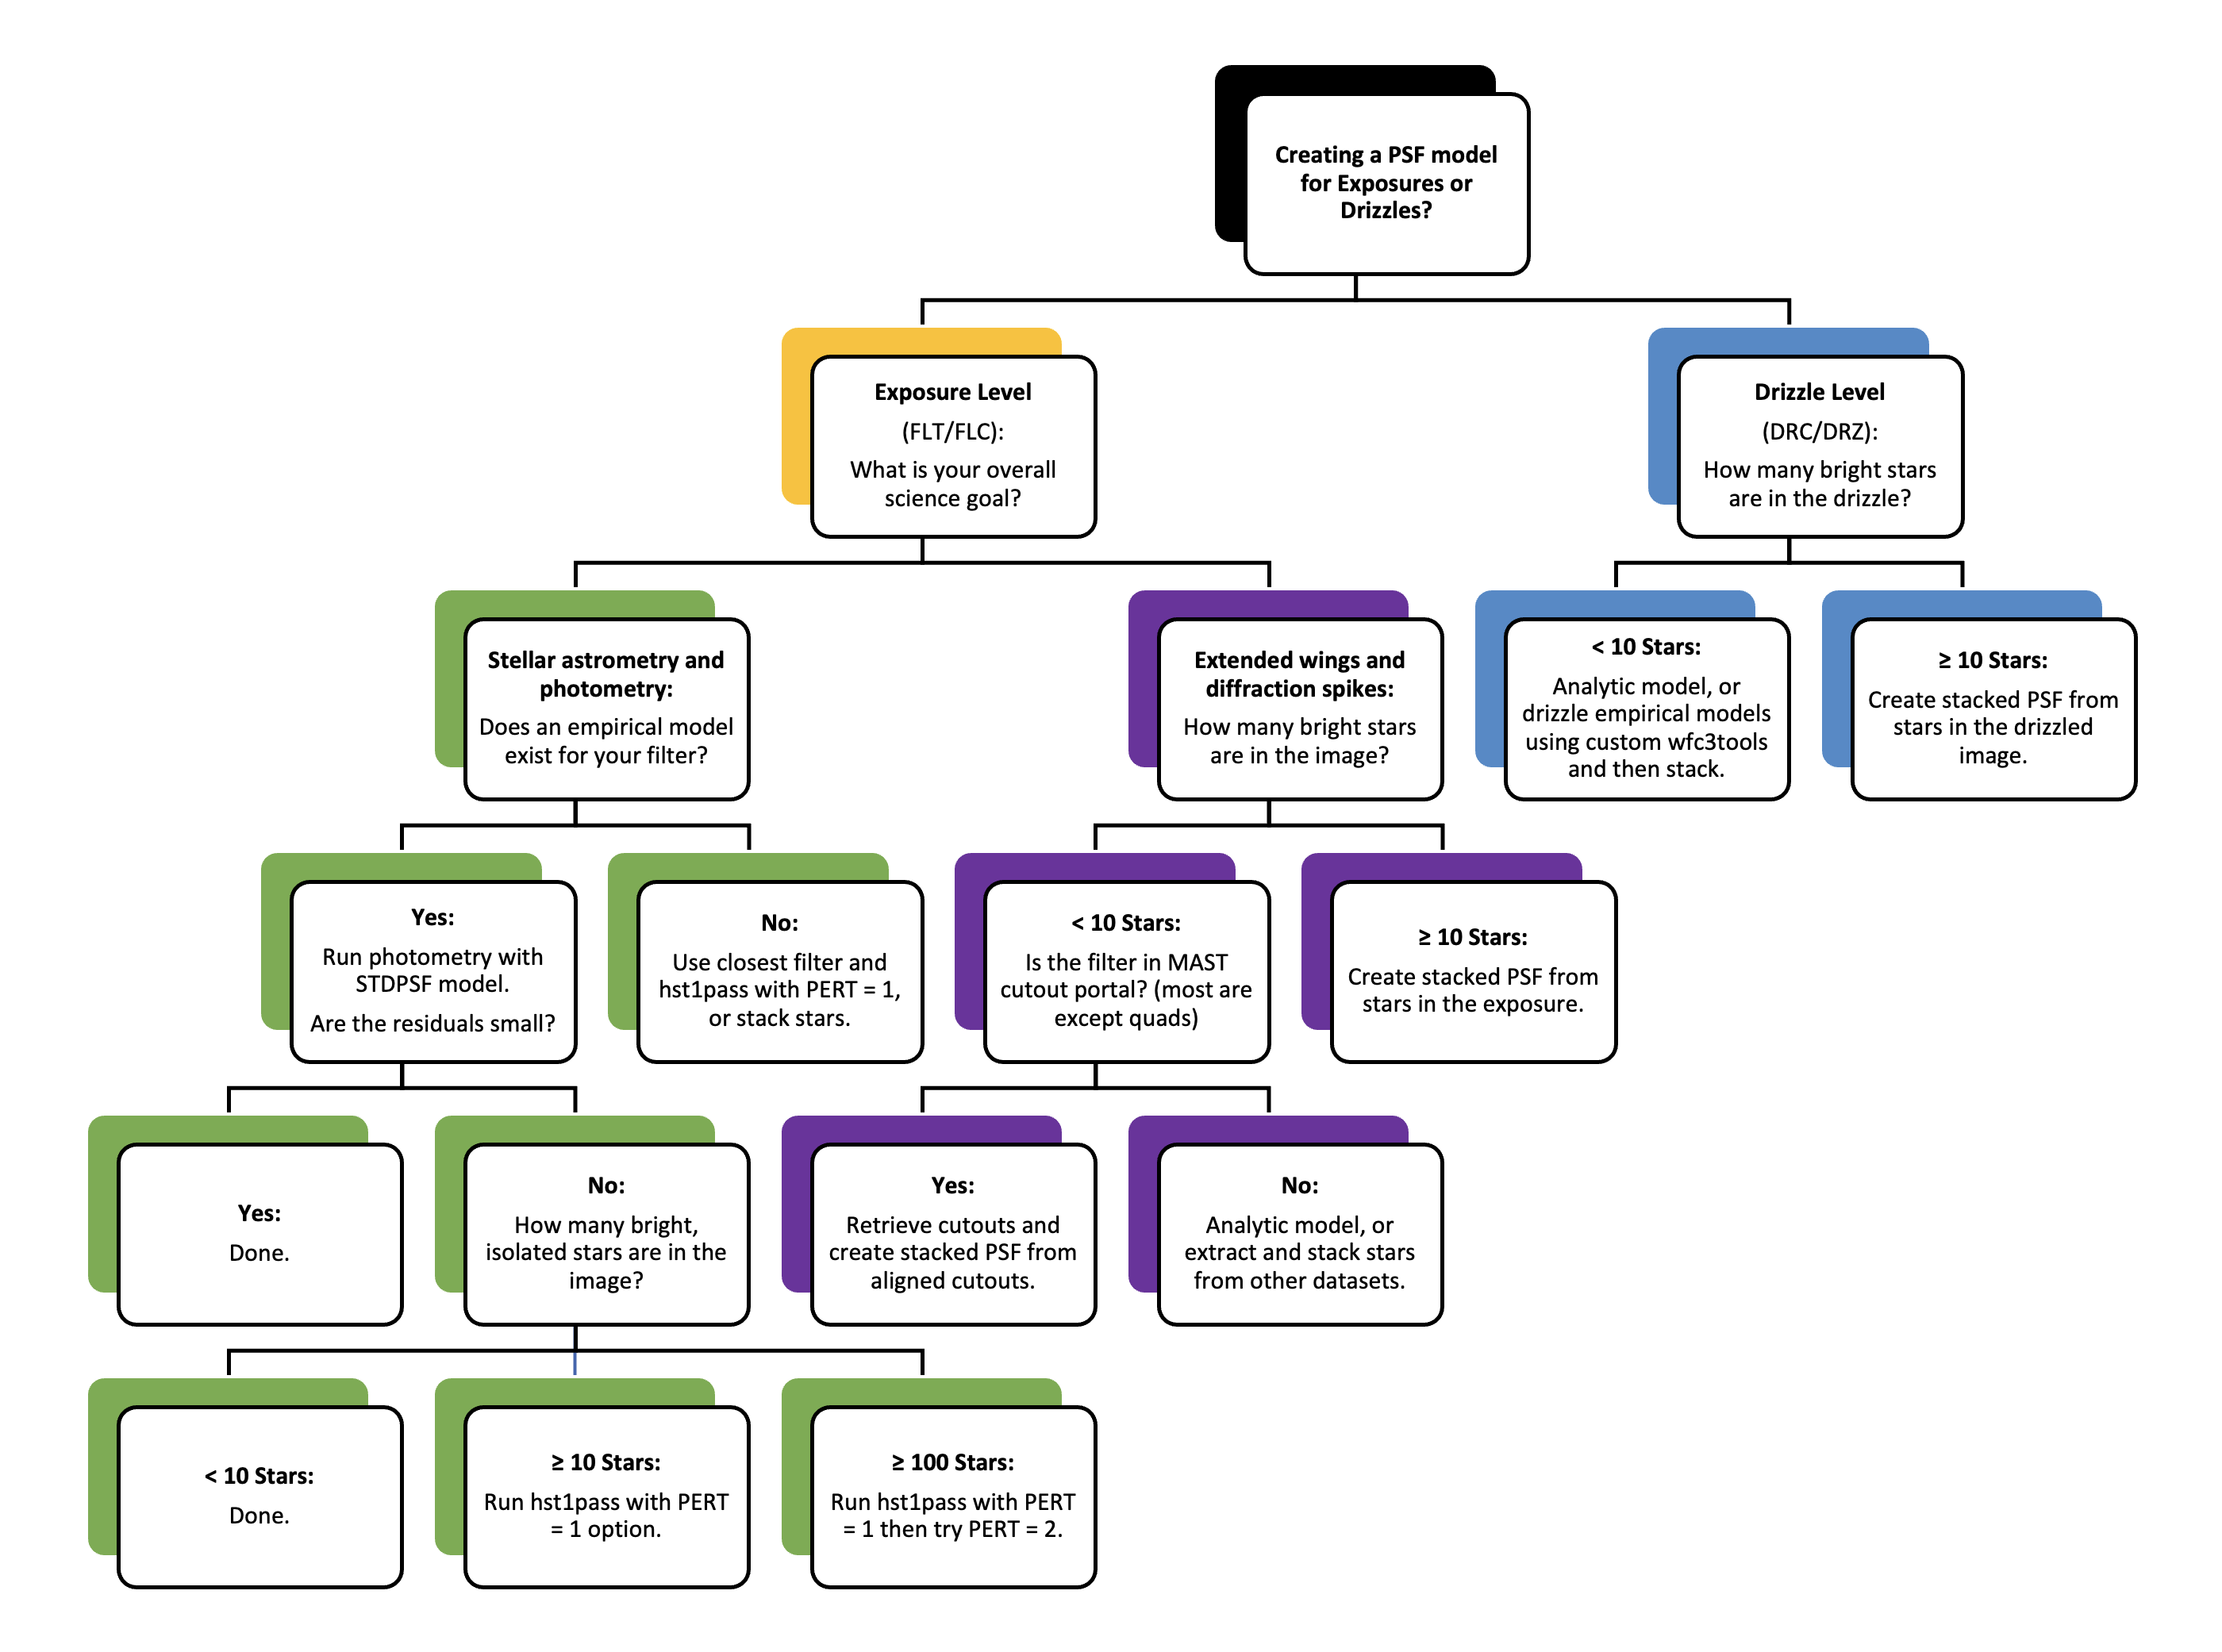

Note that the left fork for drizzle level PSFs is an advanced workflow that involves drizzling the empirical models provided by the WFC3 team into FLC files. This requires installing a custom version of [wfc3tools](https://github.com/Vb2341/wfc3tools), running the `make_model_star_image()` function, and then stacking the drizzled models. This functionality is under development and not yet officially supported.

<a id="analytical"></a>
### 2.1 Analytical PSF Models
[Table of Contents](#toc)

***

The example above demonstrates how to perform simply aperture photometry of sources. However, we can see that two of the stars overlap and their fluxes are blended. Aperture photometry cannot be used reliably for crowded fields, and requires corrections when using multiple filters as the apertures do not account for changing resolution with wavelength. Without any knowledge of the intrinsic shape of the PSF, we can first fit purely analytical functions such as a Gaussian, Moffat, Lorentzian, or Voigt profile to each star. While the majority of our functions are specified in the ```psf_utilities.py``` file, we explicitly define two common photometry functions here so users can easily experiment and change common options depending on their data and goals.

In [ ]:
def calculate_photometry(sci_data, sources, psf_model):

    '''
    A function that performs PSF photometry given a science image, 
    a list of sources, and a PSF model in the PSFPhotometry format. 
    See the photutils documentation below for additional examples:
    
    https://photutils.readthedocs.io/en/stable/psf.html
    '''

    # Perform PSF fitting using an NxN pixel region.    
    fit_shape = (9, 9)
    grouper = SourceGrouper(min_separation=20)
    finder = DAOStarFinder(threshold=500, fwhm=3.0, roundhi=0.5)
    psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=5, grouper=grouper)
    
    init_params = QTable()
    init_params['x'] = sources['xcentroid']
    init_params['y'] = sources['ycentroid']
    phot = psfphot(sci_data, init_params=init_params)
    phot['x_fit'].info.format = '.2f'
    phot['y_fit'].info.format = '.2f'
    phot['flux_fit'].info.format = '.2f'
    phot['qfit'].info.format = '.3f'
    print('\033[1m'+'\nAperture Photometry (before subtraction):\n'+'\033[0m')
    print(phot[('id', 'x_fit', 'y_fit', 'flux_fit', 'qfit')])
    print('')
    
    return phot, psfphot

In [ ]:
def calculate_residuals(resid, sources):

    '''
    A function that calculates the residual flux at the 
    locations of stars in a given PSF-subtracted image.
    '''

    # Use the PSF fitting residuals to calculate remaining fluxes.
    phot_table = aperture_photometry(resid, apertures_stellar)
    aperture_stats = ApertureStats(resid, apertures_stellar, sigma_clip=None)
    background_stats = ApertureStats(resid, apertures_annulus, sigma_clip=SigmaClip(sigma=3.0, maxiters=10))
    total_background = background_stats.median * aperture_stats.sum_aper_area.value # area of annulus.
    flux_background_sub = aperture_stats.sum - total_background
    phot_table['total_background'] = total_background
    phot_table['flux_background_sub'] = flux_background_sub
    
    for col in phot_table.colnames:  
        if col not in ('id', 'npix'):
            phot_table[col].info.format = '%.2f'

    print('\033[1m'+'\nAperture Photometry (after subtraction):\n'+'\033[0m')
    
    return print(phot_table, '\n')

In this first analytical example we fit Gaussian profiles to the four stars in our subimage and display the data, model, and residuals. We provide an initial guess for the width (sigma) using an approximate full width at half maximum (FWHM) of 2 pixels, where $\sigma$ = FWHM/2.355. Users are encouraged to experiment with this value to see how the resulting fit and residuals change.

In [ ]:
psf_model = IntegratedGaussianPRF(flux=1000, sigma=2.0/2.355)
photometry, psfphot = calculate_photometry(sci_data, sources, psf_model)
resid = psfphot.make_residual_image(sci_data, (19, 19))
figure = plot_psf_results(sci_data, resid, 1818, 986, cutout_size)
save_figure(figure, plot_dir+'fig2.pdf', True)
calculate_residuals(resid, sources)

In this case, the Gaussian fit leaves significant residual flux in the stellar wings, and has over-subtracted the emission in the core. In the next section, we improve this using models of HST data.

<a id="empirical"></a>
### 2.2 Empirical PSF Models
[Table of Contents](#toc)

***

The example above demonstrates how a Gaussian profile can determine reasonable centroids for stellar sources, but they fail to accurately model the radial light distribution. While it is possible to use more advanced analytical forms such as [Moffat profiles](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Moffat2D.html), the overall shape can be more accurately represented by models constructed from bright field stars. The examples below demonstrate how to use pre-generated models provided by the WFC3 team, as well as how to extract and stack stars from your observations. As described below, the pre-generated models are excellent for precision astrometry and photometry of unresolved sources, while stacking stars can be more beneficial for accurately modeling the PSF wings and diffration spikes.

First, we display the pre-generated PSF models provided by the WFC3 team, which are stored in a standard format known as "PSFSTD_WFC3". The FITS file for each filter contains a grid of models that represents the PSF at regularly spaced intervals across the detector, as shown below. These models are tapered to zero flux at large radii to prevent holes in image subtraction, at the expense of PSF wing accuracy. The specific details of these models are provided on the [WFC3 PSF Webpage](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/psf), as well as in the Instrument Science Report (ISR) [WFC3 2016-12](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-12.pdf).

There are also "focus-diverse" models for commonly used filters with an additional dimension containing the same grids at different focus intervals. The best fit model can be determined experimentally, or by running hst1pass to measure the focus. However, if there are a sufficient number of stars to measure the focus then hst1pass can "perturb" the pre-generated PSF models to best match the data. As this approach is generalized for any filter we do not use the focus-diverse models in this notebook. Users can find information in the ISR [WFC3 2018-14](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2018/WFC3-2018-14.pdf). While this notebook focuses on WFC3, similar focus-diverse models also exist for [ACS](http://acspsf.stsci.edu) as described in [ACS 2023-06](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2306.pdf).

Finally, in the examples below we complete only a single iteration in the PSF fitting, but it is possible to recover faint blended stars iteratively using [IterativePSFPhotometry](https://photutils.readthedocs.io/en/latest/api/photutils.psf.IterativePSFPhotometry.html#photutils.psf.IterativePSFPhotometry).

In [ ]:
hst_wfc3_f606w_psf_model = download_psf_model(psfs_dir, 'WFC3UV', 'F606W')
hdul = fits.open(hst_wfc3_f606w_psf_model, ignore_missing_end=True)
setup_matplotlib('notebook', 1.4)
psfgrid = STDPSFGrid(psfs_dir+hst_wfc3_f606w_psf_model).plot_grid()
save_figure(psfgrid, plot_dir+'psfgrid.pdf', True)

<a id="empirical-1"></a>
#### 2.2.1 Default Models
[Table of Contents](#toc)

***

First, we can simply use the pre-generated PSF models provided by the WFC3 team. In many cases, these models will be sufficient for measuring very accurate astrometry and photometry of stellar sources in individual exposures (FLCs/FLTs) without further modifications. We utilize functions within the Astropy-affiliated [photutils](https://photutils.readthedocs.io/en/stable/) package to read the models into a recognized format for the PSF fitter. As noted in the packages documentation, for ACS/WFC and WFC3/UVIS the detector value should be "1" for WFC2 UVIS2 (sci, 1), and "2" for WFC1, UVIS1 (sci, 2). We now read in the default model and use it with the PSF fitter to calculate the best fit model and residuals.

In [ ]:
model_uvis1 = GriddedPSFModel.read(hst_wfc3_f606w_psf_model, format='stdpsf', detector_id=2)
model_uvis2 = GriddedPSFModel.read(hst_wfc3_f606w_psf_model, format='stdpsf', detector_id=1)
photometry, psfphot = calculate_photometry(sci_data, sources, psf_model=model_uvis1)
resid = psfphot.make_residual_image(sci_data, (9, 9))
figure = plot_psf_results(sci_data, resid, 1818, 986, cutout_size)
save_figure(figure, plot_dir+'fig3.pdf', True)
calculate_residuals(resid, sources)

<a id="empirical-2"></a>
#### 2.2.2 Focus Perturbation
[Table of Contents](#toc)

***

In the case above, the pre-generated PSF model subtraction has substantial flux remaining in the residual image. We can use the perturbation feature within `hst1pass` to modify the shape of the PSF to better fit these specific observations. As described in this Section 3.3 of [WFC3 2022-05](https://www.stsci.edu/~jayander/JWST1PASS/DOCs/ISR_HST1PASS.pdf), the routine has a "PERT" option that can modify the library PSF if there are at least 10 relatively bright, isolated stars in the field. If PERT=1, then hst1pass constructs a single PSF that applies across the entire image. This often provides the best results, but PERT=2 can be specified to generate an NxN array of PSFs spaced evenly across the detector. This requires ample bright, isolated stars across the detector. In general, it is recommended that users begin with the unaltered PSFs before utilizing the single or spatially-dependent perturbed PSFs. The perturbed models have a small effect on astrometry and moderate on photometry.

The commands below assume that you have followed the instructions for installing hst1pass given in the [Environment Setup](#environment) section. The executable can be in the same directory as assumed below, or you can provide the full path to the location of the executable. We now call hst1pass with PERT=1 to construct a single perturbed PSF model that applies at all locations on the detector.

In [ ]:
os.chdir(data_dir)
!./../hst1pass_darwin.e HMIN=5 FMIN=1000.0 PMAX=66000.0 PERT=1 OUT=xympqks PSF=./../psfs/PSFSTD_WFC3UV_F606W.fits id8048dyq_flc.fits
clear_output()

Read in the perturbed model and examine the residuals.

In [ ]:
perturbed_psf_model = data_dir+'/id8048dyq_psf.fits'
model_uvis1 = GriddedPSFModel.read(perturbed_psf_model, format='stdpsf', detector_id=2)
model_uvis2 = GriddedPSFModel.read(perturbed_psf_model, format='stdpsf', detector_id=1)
photometry, psfphot = calculate_photometry(sci_data, sources, psf_model=model_uvis1)
resid = psfphot.make_residual_image(sci_data, (9, 9))
figure = plot_psf_results(sci_data, resid, 1818, 986, cutout_size)
save_figure(figure, plot_dir+'fig4.pdf', True)
calculate_residuals(resid, sources)

<a id="empirical-3"></a>
#### 2.2.3 Spatial Perturbation
[Table of Contents](#toc)

***

In general, using hst1pass with PERT=1 to construct a single, focus-dependent PSF model that applies across the detector will provide the best results. However, for specialized use cases with many bright, isolated stars that are located near one location on the detector, or dispersed across the entire detector, hst1pass can create a spatially-dependent PSF model in the same NxN array format as the PSFSTD_WFC3 standard models. We now use hst1pass with PERT=2 to generate a grid of spatially-dependent PSF models optimized for the focus of this exposure.

In [ ]:
os.chdir(data_dir)
!./../hst1pass_darwin.e HMIN=5 FMIN=1000.0 PMAX=66000.0 PERT=2 OUT=xympqks PSF=./../psfs/PSFSTD_WFC3UV_F606W.fits id8048dyq_flc.fits
clear_output()

Read in the perturbed model and examine the residuals.

In [ ]:
perturbed_psf_model = data_dir+'id8048dyq_psf.fits'
model_uvis1 = GriddedPSFModel.read(perturbed_psf_model, format='stdpsf', detector_id=2)
model_uvis2 = GriddedPSFModel.read(perturbed_psf_model, format='stdpsf', detector_id=1)
photometry, psfphot = calculate_photometry(sci_data, sources, psf_model=model_uvis1)
resid = psfphot.make_residual_image(sci_data, (9, 9))
figure = plot_psf_results(sci_data, resid, 1818, 986, cutout_size)
save_figure(figure, plot_dir+'fig5.pdf', True)
calculate_residuals(resid, sources)

Interestingly, the residual flux is minutely larger when using the spatially-dependent model with this dataset, which can be seen by comparing the `flux_background_sub` values for each star in the above tables. This is primarily due to the fact that there are an insufficient number of bright, isolated stars to accurately constrain the model at each location on the detector. Thus, the best solution is produced in using PERT=1 with hst1pass. This concludes the section on using empirical PSF models provided by the WFC3 team.

<a id="stacked"></a>
### 2.3 Stacked PSF Models
[Table of Contents](#toc)

***

The empirical models used above that are provided by the WFC3 team can provide excellent fits at the exposure level for very accurate astrometry and photometry. However, these models have three limitations for specific science cases. First, the models are intentionally tapered to zero flux at large radii to prevent oversubtraction and fitting of noise at large radii, which means they cannot accurately capture very extended emission of bright sources. Second, while these models are available for the majority of commonly used filters on WFC3, models are not available for more specialized narrowband and quadrant filters. Third, these models are generated in the exposure frame, and so do not accurately represent the PSF in drizzled image mosaics, which will differ depending on how the drizzle was created.

With these considerations, we now explore extracting and stacking stars from both individual exposures and drizzled mosaics. Stacking a large number of sources allows for efficient outlier rejection and can produce a high quality PSF that extends to large radii, but can inherently smear or broaden the PSF at a miniscule level depending on how the sources are aligned. In this example, we will first extract stars from our image of Omega Cen and stack them to produce a PSF model. Next, we will examine the case where there are insufficient stars in an image, and retrieve stellar cutouts from the MAST database to construct a model.

In summary, users may wish to stack stars if 1) there is no empirical model avaiable for their filter, 2) they are interested in the extended wing emission, 3) they required a PSF model with diffraction spikes at the exact angle of their observations, or 4) they need to generate a PSF model for drizzled mosaics. Users can stack stars extracted from their images, or use the MAST database cutout service to retrieve observations of a similar focus and quality for their science. We will use the hst1pass catalogs produced above for examples on the exposure level, which are the same as the centroids provided by the MAST cutout service, but users can provide coordinates from an external catalog (e.g. SourceExtractor, photutils) as desired.

<a id="stellar"></a>
#### 2.3.1 Stellar Stacks
[Table of Contents](#toc)

***

In this example, we use the hst1pass catalog to extract and stack stars from the FLC exposure of Omega Centauri. The hst1pass catalog columns are described in Section 2.3 of [WFC3 2022-05](https://www.stsci.edu/~jayander/JWST1PASS/DOCs/ISR_HST1PASS.pdf) and include `k`:chip number, `p`:peak flux, `q`:quality of fit, `s`:sky value, and `x` and `y` detector coordinates. We note that running hst1pass is not required, and users can use an external catalog generated with photutils or other packages provided the catalog contains accurate `x` and `y` coordinates. An example of this is shown in the section on [Drizzle PSF Models](#drizzles).

We first read the hst1pass catalog and select bright stars with excellent qfit values on chip two. We also require a low sky value to remove some cutouts with many neighboring stars, and create a buffer around the edges of the detector so all cutouts contain a full array of data. The `rpix` parameter sets the radius of the cutout in pixels. For example, `rpix = 19` produces a 39x39 pixel PSF model, corresponding to a size of 1.54$\times$1.54 arcseconds.

In [ ]:
# Read the hst1pass catalog and select stars.
hst1pass_cat = Table.read(data_dir+'id8048dyq_flc.xympqks', 
                          format='ascii', 
                          guess=False, 
                          fast_reader=False, 
                          data_start=1, 
                          names=['x', 'y', 'm', 'p', 'q', 'k', 's'])
print('The original catalog has', len(hst1pass_cat), 'entries.')

rpix = 19 # Set the radius in pixels for the cutouts and resulting PSF.

# Select sources with specific brightness, qfit, and location criteria.
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['k'] == 2)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['p'] >= 10000.0)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['p'] <= 63300.0)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['q'] <= 0.035)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['s'] <= 100.0)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['x'] > rpix)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['x'] < 4096.0-rpix)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['y'] > rpix)]
hst1pass_cat = hst1pass_cat[numpy.where(hst1pass_cat['y'] < 2048.0-rpix)]
star_ids = list(range(len(hst1pass_cat)))

hst1pass_cat

In [ ]:
star_cutouts = make_cutouts(image=sci_data, 
                            star_ids=star_ids, 
                            xis=hst1pass_cat['x'], 
                            yis=hst1pass_cat['y'], 
                            rpix=rpix, 
                            scale_stars=True, 
                            sub_pixel=True, 
                            show_figs=True, 
                            verbose=True)

In [ ]:
star_stack = stack_cutouts(star_cutouts, 
                           rpix=rpix, 
                           stack_type='median', 
                           scale_flux=True, 
                           export_file=psfs_dir+'hst_wfc3_uvis_f606w_star_psf_model.fits')

Finally, we provide our stacked model to the photutils [FittableImageModel](https://photutils.readthedocs.io/en/stable/api/photutils.psf.FittableImageModel.html) function, which allows it to be used with the PSF fitting tools in photutils. While the core emission was better fit using the empirical models in the previous section, using the stacked model that is not tapered to zero flux allows us to fit out to large radii, which is set to 19 pixels below.

In [ ]:
star_stack_psf = FittableImageModel(star_stack[0])
photometry, psfphot = calculate_photometry(sci_data, sources, psf_model=star_stack_psf)
resid = psfphot.make_residual_image(sci_data, (19, 19))
figure = plot_psf_results(sci_data, resid, 1818, 986, cutout_size)
save_figure(figure, plot_dir+'fig6.pdf', True)
calculate_residuals(resid, sources)

<a id="mast"></a>
#### 2.3.2 MAST Stacks
[Table of Contents](#toc)

***

The example above demonstrates how to extract and stack stars from a provided exposure. However, in many cases there may be an insufficient number of stars to create a high-quality median stack. In those cases, users can utilize the MAST cutout database described in [Dauphin et al. (2020) [WFC3 2021-12]](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/ISR_2021_12.pdf), with acces instructions provided on the [PSF Search](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/psf/psf-search) webpage. The MAST API commands are listed on [this webpage](https://mast.stsci.edu/api/v0/pyex.html#MastCatalogsFilteredWfc3PsfUvisPy), with parameter options on [this webpage](https://mast.stsci.edu/api/v0/_w_f_c3__p_s_ffields.html). The examples below utilize sections of code from the `download_psf_cutouts.ipynb` developed by Dauphin et al. (*in preparation*). In this case, we set limits on the x and y detector locations, quality of fit, exposure time, isolation index, integrated flux (in electrons for WFC3/UVIS and WFPC2, and in electrons per second for WFC3/IR), the central pixel flux, sky flux, and exclude subarrays.

<div class="alert alert-block alert-info"><b>NOTE:</b> We explicitly assume that users have familiarized themselves with the contents of the "download_psf_cutouts.ipynb" notebook for this section. </div>

In [ ]:
os.chdir(code_dir)

# Searching a larger radius around our cutout for a sufficient number of stars.
x_min_max = mast_api_psf.set_min_max(1818-cutout_size*5, 1818+cutout_size*5)
y_min_max = mast_api_psf.set_min_max(986-cutout_size*5, 986+cutout_size*5)
qfit_min_max = mast_api_psf.set_min_max(0.0, 0.05)
exp_time = mast_api_psf.set_min_max(10, 30000)
iso_index = mast_api_psf.set_min_max(20, 4096)
psf_flux = mast_api_psf.set_min_max(2000, 1000000000) # This is an integrated value so set an arbitarily large upper bound.
pixc = mast_api_psf.set_min_max(59000, 63300)
sky_flux = mast_api_psf.set_min_max(0, 50)
subarray = mast_api_psf.set_min_max(0, 0)
focus = mast_api_psf.set_min_max(-10, 10) # Change these values to see the effects of focus.

detector = 'UVIS'

parameters = {
    'psf_x_center': x_min_max,
    'psf_y_center': y_min_max,
    'n_sat_pixels': ['0'],
    'filter': ['F606W'],
    'qfit': qfit_min_max,
    'exptime': exp_time,
    'iso_index': iso_index,
    'mtflag': ['0'],
    'pixc': pixc,
    'subarray': subarray,
    'psf_flux': psf_flux,
    'sky': sky_flux, 
    'focus': focus
}
filts = mast_api_psf.set_filters(parameters)
columns = ['id', 'rootname', 'filter', 'chip', 'exptime', 'psf_x_center', 'psf_y_center', 'pixc', 'sky', 'qfit', 'iso_index', 'subarray']
obs = mast_api_psf.mast_query_psf_database(detector=detector, filts=filts, columns=columns)
obs

In [ ]:
os.chdir(data_dir)
file_suffix = ['flc'] # was flt
dataURIs = mast_api_psf.make_dataURIs(obs, detector=detector, file_suffix=file_suffix)
filename = mast_api_psf.download_request(dataURIs, filename='mastDownload.tar.gz', download_type='bundle.tar.gz')
tar = tarfile.open(filename, 'r:gz')
path_mast = tar.getnames()[0]
tar.extractall()
tar.close()
path_data = sorted(glob.glob(f'{path_mast}/*/*'))
mast_cutouts = numpy.array([fits.getdata(path) for path in path_data])

In [ ]:
os.chdir(data_dir)
plot_cutout_grid(cutouts=mast_cutouts, path_data=path_data, max_cutouts=50, verbose=False)
save_figure(figure, plot_dir+'fig7.pdf', True)

In [ ]:
mast_stack = stack_cutouts(mast_cutouts, 
                           rpix=25, 
                           stack_type='median', 
                           scale_flux=True, 
                           export_file=psfs_dir+'hst_wfc3_uvis_f606w_mast_psf_model.fits')

We now use this model to perform PSF fitting and subtraction on the science image. We see that the cutouts retrieved and stacked from MAST only marginally fit the shapes of the stars in this particular exposure, similar to the results that we obtained with the empirical model before perturbation. The model could be revised by querying the MAST cutout service with different parameters and/or carefully selecting cutouts based on their full width at half maxima. The optimal workflow will depend on the dataset and science goals.

In [ ]:
mast_stack_psf = FittableImageModel(mast_stack[0])
photometry, psfphot = calculate_photometry(sci_data, sources, psf_model=mast_stack_psf)
resid = psfphot.make_residual_image(sci_data, (9, 9))
figure = plot_psf_results(sci_data, resid, 1818, 986, cutout_size)
save_figure(figure, plot_dir+'fig8.pdf', True)
calculate_residuals(resid, sources)

<a id="drizzles"></a>
## 3. Drizzle PSF Models
[Table of Contents](#toc)

***

The examples in Section 2 apply to PSF modeling at the exposure level. However, in many cases with faint astronomical sources, multiple exposures are combined through drizzling to yield an image mosaic with increased signal-to-noise that is free from artifacts such as cosmic rays and hot pixels. The process of drizzling is beyond the scope of this notebook, and users can find more information on the [DrizzlePac Website](https://www.stsci.edu/scientific-community/software/drizzlepac), including a series of [tutorial notebooks](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/DrizzlePac) with useful examples, and a brief explanation [here](https://www.stsci.edu/~fruchter/dither/drizzle.html?fbclid=IwAR3mrcUR7kxAZuDk7l6GUQtuJKrs-ecvv5YHSmWYfM64EgXP3unqp02Rdpk). In this case, it is sufficient to note that drizzling allows us to account for undersampling of the WFC3 detectors to recover the full spatial resolution of HST, and account for distortion across the field of view to provide a flux-conserved, geometrically rectified mosaic generated from the individual exposures.

In this case, we combine three F606W exposures covering the same area of Omega Cen, and focused on the same four stars shown in [Section 1.4](#aperture).

<a id="create"></a>
### 3.1 Create Drizzle
[Table of Contents](#toc)

***

In the cell below, we first download the three F606W exposures and copy them to a new directory because their headers will be modified in the alignment and drizzling process.

In [ ]:
os.chdir(data_dir)

tweak_files = ['id8048e0q_flc.fits', 'id8048dyq_flc.fits', 'id8048e3q_flc.fits']

for tweak_file in tweak_files:
    print('Copying', tweak_file)
    Observations.download_file('mast:HST/product/'+tweak_file, local_path=data_dir+tweak_file, cache=True)
    shutil.copy2(tweak_file, tweak_dir)
    
os.chdir(tweak_dir)

# Call TweakReg.
tweakreg.TweakReg(tweak_files,
                  refimage=tweak_files[0],
                  expand_refcat=True,
                  clean=True,
                  interactive=False,
                  updatehdr=True,
                  reusename=False,
                  wcsname='TWEAK', 
                  descrip='HST WFC3 PSF Notebook Example',
                  catalog=tweak_files[0],
                  shiftfile=True,
                  outshifts='tweakreg_shifts.dat',
                  minobj=100,
                  searchrad=0.25,
                  searchunits='arcseconds',
                  fitgeometry='rscale',
                  nclip=5,
                  sigma=3.0,
                  imagefindcfg={'threshold': 50, 'peakmax': 62000, 'use_sharp_round': True},
                  refimagefindcfg={'threshold': 50, 'peakmax': 62000, 'use_sharp_round': True})

clear_output()

Now, we examine the TweakReg residuals to confirm they are small. The columns are filename, shift in x, shift in y, rotation in degrees, plate scale, and the x and y RMS errors on the shift. In general, RMS values below $\approx$ 0.1 pixels are desired for a quality alignment solution. A value of NaN indicates a failure and the search parameters should be adjusted.

In [ ]:
os.chdir(tweak_dir)
shift_table = Table.read('tweakreg_shifts.dat', 
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
print(shift_table)

Next, we use AstroDrizzle to combine the aligned exposures into a single mosaic.

In [ ]:
os.chdir(tweak_dir)

for driz_file in tweak_files:
    print('Copying', driz_file, 'to the drizzle directory.')
    shutil.copy2(driz_file, driz_dir)
    
os.chdir(driz_dir)

# Run AstroDrizzle.
astrodrizzle.AstroDrizzle(tweak_files,
                          output='omega_cen_f606w_drz.fits', # The output filename.
                          wcskey='TWEAK',              # Use tweakreg WCS solution.
                          build=True,                  # Save separate SCI and WHT.
                          updatewcs=False,             # Don't run updatewcs again.
                          stepsize=1,                  # Don't interpolate the WCS.
                          num_cores=1,                 # Single core saves memory.
                          preserve=False,              # We save the files separately.
                          clean=True,                  # We may want mask files later.
                          skysub=True,                 # Definitely subtract the sky.
                          skymethod='globalmin+match', # Recommended for diffuse data.
                          combine_type='iminmed',      # 'iminmed' for < 10 images.
                          driz_cr_corr=False,          # Save the cosmic-ray masks.
                          driz_combine=True,           # Use all images in drizzle.
                          final_wht_type='EXP',        # EXP weight for bright objects.
                          final_pixfrac=0.8,           # Fraction to shrink drops by.
                          final_units='cps')           # Set units to counts per second.

clear_output()

Finally, we can display the drizzled image and highlight the same boxed region shown in Sections 1-2. The mosaic displays a significantly smoother background that the individual exposures, without significant cosmic rays or hot pixels. Stars that were saturated in the original FLCs contain artifacts and so should not be used in stacking.

In [ ]:
hdul = fits.open(driz_dir+'omega_cen_f606w_drz.fits')
sci_driz = numpy.nan_to_num(hdul['SCI'].data)
print('The image dimensions are:', numpy.shape(sci_driz))

my_figure_size, my_fontsize = setup_matplotlib('notebook', 1.2)
figure, axes = matplotlib.pyplot.subplots(1, 1, figsize=my_figure_size)
cutout_size = 75 # 75 WFC3 UVIS pixels = 3 arcseconds.

# Same box is at: 1823.5781, 1096.5125
axes.add_patch(Rectangle((1823.5781-cutout_size/2, 1096.5125-cutout_size/2), width=cutout_size, height=cutout_size, fill=None, color='w'))
norm = simple_norm(sci_driz, 'sqrt', percent=99.8-0.2)
axes.imshow(sci_driz, cmap='gray', origin='lower', aspect='equal', interpolation='nearest', norm=norm)
matplotlib.pyplot.show()

<a id="stack"></a>
### 3.2 Stack Stars
[Table of Contents](#toc)

***

Next, we want to detect a significant number of stars across the image that surround the location of interest. Specifically, so we have a sufficient number of stars for stacking (> 10) that are located near the location on the detector for which we want to construct a PSF model. In this case we select a 525$\times$525 pixel region near the four stars shown above.

In [ ]:
# Calculate statistics for the background, initialize the star finder, locate the stars, and assign flux apertures.
mean, median, std = sigma_clipped_stats(sci_driz, sigma=3.0)
daofind = DAOStarFinder(threshold=2.5, fwhm=3.0, roundhi=0.5)
mask = create_mask(sci_driz, cutout_size=cutout_size*7.0, xcenter=1823, ycenter=1096)
sources = daofind(sci_driz - median, mask=mask)
positions = numpy.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_stellar = CircularAperture(positions, r=5.0)
apertures_annulus = CircularAnnulus(positions, r_in=9, r_out=12)
phot_table = aperture_photometry(sci_driz, apertures_stellar)

# Calculate the sigma-clipped background levels and subtract that from the flux measured within the stellar aperture.
aperture_stats = ApertureStats(sci_driz, apertures_stellar, sigma_clip=None)
background_stats = ApertureStats(sci_driz, apertures_annulus, sigma_clip=SigmaClip(sigma=3.0, maxiters=10))
total_background = background_stats.median * aperture_stats.sum_aper_area.value # area of annulus.
flux_background_sub = aperture_stats.sum - total_background
phot_table['total_background'] = total_background
phot_table['flux_background_sub'] = flux_background_sub

# for col in phot_table.colnames:  
#     if col not in ('id', 'npix'):
#         phot_table[col].info.format = '%.2f'
# print('\n', phot_table, '\n')

plot_apertures(data=sci_driz, 
               xcenter=1823, 
               ycenter=1096, 
               cutout_size=cutout_size*7.0, 
               apertures_stellar=apertures_stellar, 
               apertures_annulus=apertures_annulus)

save_figure(figure, plot_dir+'fig8.pdf', True)

Now we use the photometric catalog to select stars from the drizzled image for stacking. In this case we shift the catalog coordinates by one pixel so that the image and catalog both have the same origin of one, rather than being zero based. Here we use the centroids obtained directly from the photometric catalog, which yields coordinates that agree with the center of mass within $\lesssim$ 0.05 pixels. This is sufficient for many science cases, but it may be possible to improve the alignment by using the stacked model to fit the stars with the [PSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.PSFPhotometry.html#photutils.psf.PSFPhotometry) package and iterating the fits until the centroids converge to stable values.

In [ ]:
star_ids = list(phot_table['id'].value)
xis = [x+1 for x in list(phot_table['xcenter'].value)]
yis = [y+1 for y in list(phot_table['ycenter'].value)]

driz_cutouts = make_cutouts(image=sci_driz, 
                            star_ids=star_ids, 
                            xis=xis, 
                            yis=yis, 
                            rpix=rpix, 
                            scale_stars=True, 
                            show_figs=True, 
                            sub_pixel=True)

In [ ]:
driz_stack = stack_cutouts(driz_cutouts, 
                           rpix=rpix, 
                           stack_type='median', 
                           scale_flux=True, 
                           export_file=psfs_dir+'hst_wfc3_uvis_f606w_driz_psf_model.fits')



We now isolate the same four stars show at the exposure level in Sections 1-2. The drizzled image has a substantially smoother background with cosmic ray and hot pixel artifacts removed by the drizzling process. In addition, a faint fifth star that was barely detectable at the exposure level is now readily visible and could also be analyzed.

In [ ]:
# Calculate statistics for the background, initialize the star finder, locate the stars, and assign flux apertures.
mean, median, std = sigma_clipped_stats(sci_driz, sigma=3.0)
daofind = DAOStarFinder(threshold=5, fwhm=3.0, roundhi=0.5)
mask = create_mask(sci_driz, cutout_size, 1823, 1096)
sources = daofind(sci_driz - median, mask=mask)
positions = numpy.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_stellar = CircularAperture(positions, r=5.0)
apertures_annulus = CircularAnnulus(positions, r_in=9, r_out=12)
phot_table = aperture_photometry(sci_driz, apertures_stellar)

# Calculate the sigma-clipped background levels and subtract that from the flux measured within the stellar aperture.
aperture_stats = ApertureStats(sci_driz, apertures_stellar, sigma_clip=None)
background_stats = ApertureStats(sci_driz, apertures_annulus, sigma_clip=SigmaClip(sigma=3.0, maxiters=10))
total_background = background_stats.median * aperture_stats.sum_aper_area.value # area of annulus.
flux_background_sub = aperture_stats.sum - total_background
phot_table['total_background'] = total_background
phot_table['flux_background_sub'] = flux_background_sub

for col in phot_table.colnames:  
    if col not in ('id', 'npix'):
        phot_table[col].info.format = '%.2f'
print('\n', phot_table, '\n')

plot_apertures(data=sci_driz, 
               xcenter=1823, 
               ycenter=1096, 
               cutout_size=cutout_size, 
               apertures_stellar=apertures_stellar, 
               apertures_annulus=apertures_annulus)

save_figure(figure, plot_dir+'fig9.pdf', True)

Finally, we use the stacked model from the drizzled image to perform a PSF fit and subtraction of the same four stars examined earlier. Overall, the model accurately encapsulates the total flux of each star, but some artifacts remain because drizzled images resample the observations.

In [ ]:
driz_stack_psf = FittableImageModel(driz_stack[0])
photometry, psfphot = calculate_photometry(sci_driz, sources, psf_model=driz_stack_psf)
resid = psfphot.make_residual_image(sci_driz, (17, 17))
figure = plot_psf_results(sci_driz, resid, 1823, 1096, cutout_size)
save_figure(figure, plot_dir+'fig10.pdf', True)
calculate_residuals(resid, sources)

In [ ]:
os.system("say 'Thank you for completing this tutorial. Your notebook has finished running.'")

<a id="conclusions"></a>
## Conclusions
[Table of Contents](#toc)

***

We hope this notebook has provided valuable information and examples for constructing HST WFC3 PSF models. While the focus in this notebook is for the WFC3 instrument, the same principles apply to HST Advanced Camera for Surveys (ACS) observations, as well as archival Wide Field and Planetary Camera 2 (WFPC2) observations. See [Anderson 2006 [ACS 2006-01]](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr0601.pdf) for more information on the ACS PSF models. Finally, users may find several helpful resources on the [WFC3 Software Tools webpage](https://www.stsci.edu/hst/instrumentation/wfc3/software-tools).

<a id="about"></a>
## About this Notebook
[Table of Contents](#toc)

***

**Author:** Mitchell Revalski<br>
**Created:** 15 Apr 2024<br>
**Updated:** 21 May 2024<br>
**Source:** [https://github.com/spacetelescope/hst_notebooks](https://github.com/spacetelescope/hst_notebooks)

<a id="additional"></a>
### Additional Resources

Below are some additional resources that may be helpful. Please send any questions to the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 PSF Website](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/psf)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)


<a id="cite"></a>
### Software Citations
If you use Python packages such as `astropy`, `astroquery`, `drizzlepac`, `matplotlib`, or `numpy` for published research, please cite the authors.

Follow the links below for more information about citing various packages:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `drizzlepac`](https://zenodo.org/records/3743274)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://www.scipy.org/citing.html#numpy)
***

[Top of Page](#top)
<img style="float: right;"
src = "https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>